In [1]:
import sys
sys.path.append("./../common/")
from utils import *
from config import *

# configuring to be deterministic for reproducibility
tf.keras.utils.set_random_seed(RND_SEED)
tf.config.experimental.enable_op_determinism()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 2.10.0


In [2]:
def build_train_NN(x_train, y_train, epochs):
    # build NN
    z = np.log(np.expm1(1.))
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(2, activation='relu'),
        tf.keras.layers.Dense(2),
        tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.Normal(loc=t[..., :1],
                                    scale=1e-5 + 0.1*tf.nn.softplus(z + t[..., 1:])
                                    )
                )
    ])

    model.compile(loss=nll, optimizer=tf.optimizers.Adam(learning_rate=1e-3))

    # train NN
    model.fit(x_train, y_train, epochs=epochs, verbose=0)
    return model

2023-01-06 22:22:51.203459: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


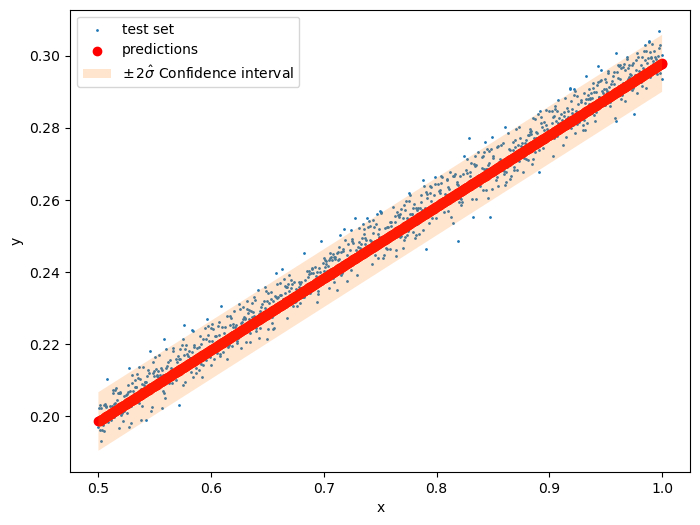

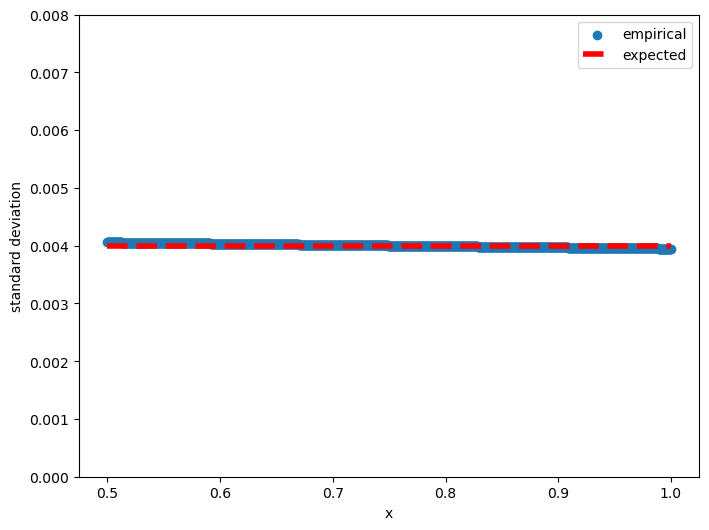

In [3]:
N = 1000
m, c = 0.2, 0.1
sd_e = 0.02

x_train = np.linspace(0, 0.5, N)[:, np.newaxis]
y_train = m*(x_train + np.random.normal(0, sd_e, N).reshape(-1, 1)) + c
x_test = np.linspace(0.5, 1, N)[:, np.newaxis]
y_test = m*(x_test + np.random.normal(0, sd_e, N).reshape(-1, 1)) + c

model = build_train_NN(x_train, y_train, 5000)

# get NN outputs
outputs = model(x_test)
y_pred = outputs.mean()
y_sd = outputs.stddev()

# calculate and plot CIs
ci_lower = y_pred - 2 * y_sd
ci_upper = y_pred + 2 * y_sd
fig = plt.figure()
plt.scatter(x_test, y_test, label='test set', s=1)
plt.scatter(x_test, y_pred, label='predictions', c='r')
plt.fill_between(np.squeeze(x_test), np.squeeze(ci_lower), np.squeeze(ci_upper), alpha=.2, label='$\pm\,2\hat\sigma$ Confidence interval')
save_xy_graph(fig, "x", "y", figures_dir, 'nn_ci_x.png')

# plot standard deviation
equation_var = (m**2)*(sd_e**2)
equation_sd = np.sqrt(equation_var)
fig = plt.figure()
plt.scatter(x_test, y_sd, label="empirical")
plt.plot([np.min(x_test), np.max(x_test)], [equation_sd, equation_sd], '--', c = "red", label="expected", linewidth=4)
plt.ylim([0, 2*equation_sd])
save_xy_graph(fig, "x", "standard deviation", figures_dir, 'nn_sigma_x.png')

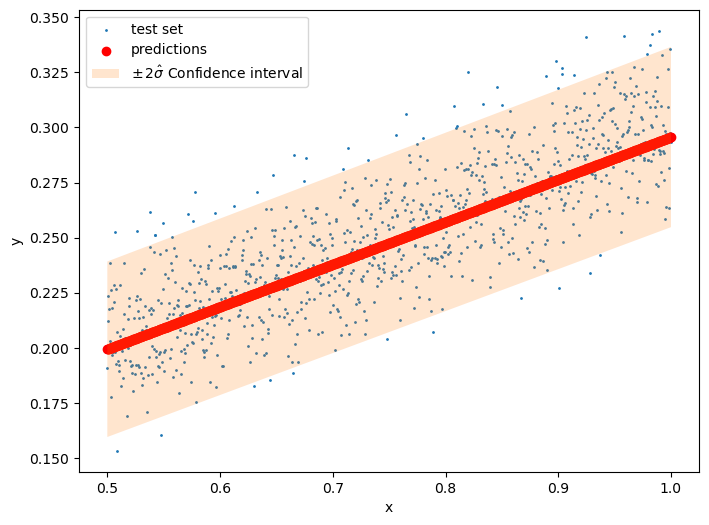

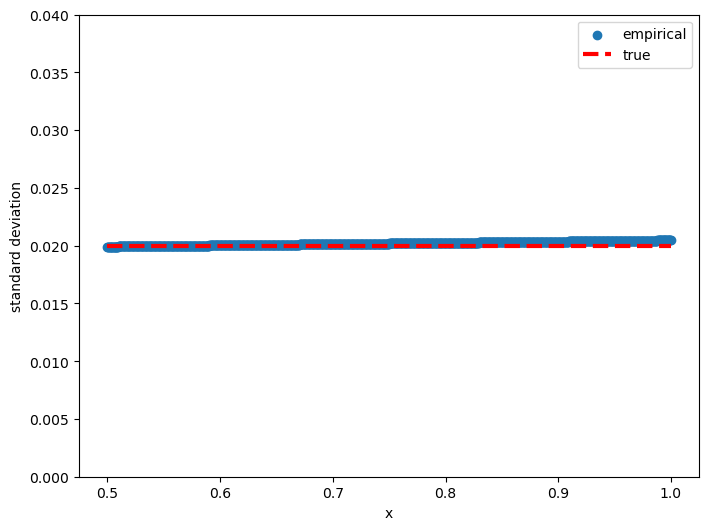

In [4]:
N = 1000
m, c = 0.2, 0.1
sd_e = 0.02

x_train = np.linspace(0, 0.5, N)[:, np.newaxis]
y_train = m*x_train + c + np.random.normal(0, sd_e, N).reshape(-1, 1)
x_test = np.linspace(0.5, 1, N)[:, np.newaxis]
y_test = m*x_test + c + np.random.normal(0, sd_e, N).reshape(-1, 1)

model = build_train_NN(x_train, y_train, 2500)

# get NN outputs
outputs = model(x_test)
y_pred = outputs.mean()
y_sd = outputs.stddev()

# calculate and plot CIs
ci_lower = y_pred - 2 * y_sd
ci_upper = y_pred + 2 * y_sd
fig = plt.figure()
plt.scatter(x_test, y_test, label='test set', s=1)
plt.scatter(x_test, y_pred, label='predictions', c='r')
plt.fill_between(np.squeeze(x_test), np.squeeze(ci_lower), np.squeeze(ci_upper), alpha=.2, label='$\pm\,2\hat\sigma$ Confidence interval')
save_xy_graph(fig, "x", "y", figures_dir, 'nn_ci_y.png')

# plot standard deviation
fig = plt.figure()
plt.scatter(x_test, y_sd, label="empirical")
plt.plot([np.min(x_test), np.max(x_test)], [sd_e, sd_e], '--', c = "red", label="true", linewidth=3)
plt.ylim([0, 2*sd_e])
save_xy_graph(fig, "x", "standard deviation", figures_dir, 'nn_sigma_y.png')